# To monitor or control?

The following notebook is a guide to applying the methods described in the manuscript *When to monitor or control; informed invasive species management using a partially observable Markov decision process (POMDP) framework*.

In [1]:
# ensure required packages are installed
import sys
!{sys.executable} -m pip install -r "requirements.txt"

# import local dependencies
# these are the scripts that carry out the methods we describe
import plotting_functions, action_value, simulations

Defaulting to user installation because normal site-packages is not writeable


## Parameter settings

The next section sets the parameters which describe the invasive species at hand. Their precise meanings are described in Section 2 and Table 1 of the manuscript. As an illustrative example, we use the control of invasive tropical fire ants on Ashmore reef. The source of these parameter values is described in Section 4 of the manuscript.

- First, the cost parameters must be set. In our model everything is scaled in units of species abundance: for example, if each uncontrolled fox costs *$1,000* to stakeholders, all costs should be divided by *1000*. In the case of Ashmore reef, the units of ant abundance are arbitrary (based on the monitoring method), and the total cost of the eradication project is attributed to the inital ant abundance.
- Control efficacy is defined as the proportional reduction in the species abundance from one application of control. Similarly, the disease grows at exponential rate *r±dr* each time step. In our case, these values are taken from the model of (Baker et al, 2017).
- Finally, the optimisation horizon and discount factor must be set.

In [2]:
# setting parameters

# costs in in $AUD million
failure_cost = 2.32 # total cost of eradication project
init_activity = 90.5866 # initial ant activity
cost_unit = failure_cost/init_activity
monitor5 = 0.158890 # 5-yearly monitoring cost
bait_a2 = .815 # cost of control plan "A2" as in (Walshe, 2017)

# growth and control efficacy
r = 2.82
dr = 0.015
rho = 0.9989054351771577 # efficacy

# for simplicity, we assume monitoring has no error, and does not itself control the species
err_mon = 0
mon_rho = 0

num_steps = 2 # optimisation horizon
gamma = 0.9 # discount factor

# package these values into dictionaries
interventions = {'ignore':(0.0,0.0), 'control':((bait_a2)/cost_unit, rho)}
mon_dict = {'monitor':(monitor5/(cost_unit),err_mon,mon_rho)}

params = dict(interventions=interventions,
                mon_dict=mon_dict,
                gamma=gamma,
                r=r,
                dr=dr,
                num_steps=num_steps,
                waiting_steps=None)

## Calculating expected costs

From here, we have everything we need to compute the expected costs of a given scenario, using `action_value.py`. This can be done for one particular sequence of actions, or for all possible sequences at once. The latter is streamlined so as to not repeat calculations.

- Expected costs are parametrised by n (median log abundance) and dn (standard deviation on log scale).
- Sequences of actions are named as in the dictionaries "interventions" and "mon_dict", separated by commas.

In [3]:
# compute expected costs
from math import log,exp

mu = 0.15 # we use mu to denote the *expected* abundance, on natural scale

# on the log scale, n is the median abudance, dn the standard deviation
# then, mu = exp(n + dn*dn/2), for our choice of lognormal distribution
dn = 1.2
n = log(mu) - dn*dn/2

print(f"Set n = {n:.2f} and dn = {dn}, so that mu = {exp(n + dn*dn/2):.2f}")

# set an action sequence
seq = 'control,ignore'

# compute expected cost using action_value.Q
# arguments are seq (action sequence), n, dn, and the parameters in the dictionary set above
# these keyword paramters can be set individually, or unpacked using python's ** operator
print(f"Expected cost of {seq} = {action_value.Q(seq,n,dn,**params):.2f}")

# On the other hand, we can ask for a dictionary with the expected cost of every action sequence
q_dict = action_value.Q_all(n,dn,**params)
print('\nAll expected costs:')
for seq,value in q_dict.items():
    print(f"{seq:25} = {value:.2f}")

Set n = -2.62 and dn = 1.2, so that mu = 0.15
Expected cost of control,ignore = 32.01

All expected costs:
ignore,ignore             = 37.92
ignore,control            = 31.14
control,ignore            = 32.01
control,control           = 60.62
monitor                   = 41.04


## Decision plots

The opimum decision changes, depending on the values of n and dn. To visualise this, we can assign each sequence a colour and plot the optimum choice on the mu-dn plane.

As an aside, the colours are chosen to give similar colours to action sequences which match for some number of steps - this is the purpose of `tree_colours.py`. An example can be seen in Figure 2b of the manuscipt.

100%|██████████| 999/999 [00:07<00:00, 141.84it/s]


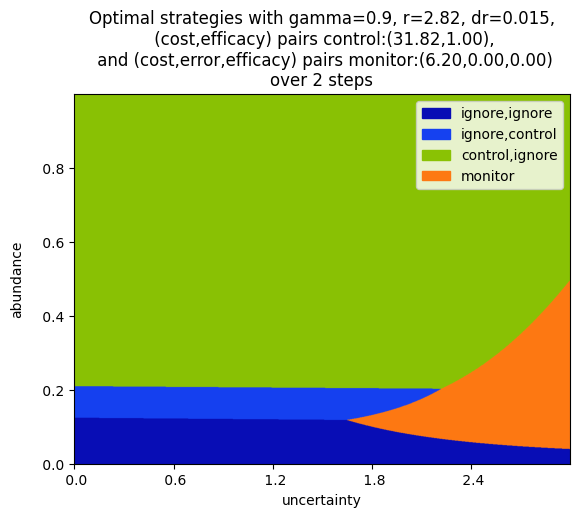

In [4]:
# plot decisions on the mu-dn plane

# set ranges for the axes, and the number of pixels in each direction
dn_range = (0,3)
mu_range = (0,1)
num_pixels = 1000

# how many steps to plot, defaults to num_steps
detail = None

plotting_functions.plot_regions(mu_range,dn_range,num_pixels,detail,plot_title=True,**params);
# semicolon so as to skip printing the return value, which is the colour key in RGBA format

## Simulations

Finally, we demonstrate simulating a possible trajectory of the system using `simulations.py`. The methodology is as follows.

- We start with a particular *true state* and belief of the manager, which may differ.
- At each step, the manager uses our methodology to pick an action, and updates their belief accordingly. 
- The true state changes based on this action, and a growth rate chosen from a normal distribution centred at r, with standard deviation dr.

     true_n         n     dn   action  rew_sofar
0 -1.703052 -3.386294  2.000     None   0.000000
1 -5.685029 -7.383693  2.015  control  32.004575
2 -2.876401 -4.563693  2.030   ignore  32.007971
3 -0.042866 -0.042866  0.015  monitor  38.268319
4 -4.032749 -4.040264  0.030  control  71.048807
5 -1.217447 -1.220264  0.045   ignore  71.066532


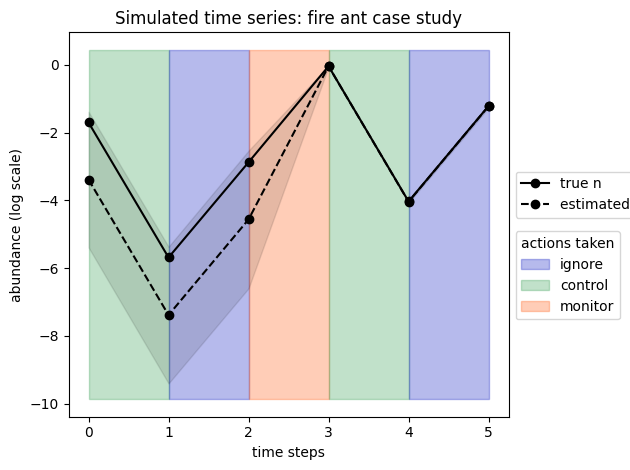

In [5]:
# simulations

# pick a starting belief
init_dn = 2
init_mu = .25
init_n = log(init_mu) - init_dn**init_dn/2

# choose a true state, based (say) on a percentile of the belief distribution
from scipy.stats import norm
percentile = 80 # indicates the belief *underestimates* the true state
init_true_n = norm.ppf(percentile/100, loc=init_n, scale=init_dn)

seq_len = 5 # run the simulation for this many steps, with a moving decision horizon

# run the simulation
# for the purposes of comparision, the results are simulated for the full model, and for
# a naive model which does not involve monitoring
sequences, final_rewards = simulations.run_sim(init_true_n, init_n, init_dn, seq_len, **params)

# package the full model into a pandas dataframe for easy display
# the columns correspond to the true state & belief, the action taken, and the cumulative reward
import pandas as pd
full_model_sequence = pd.DataFrame(sequences['full'])
print(full_model_sequence)

# NB: in row i, the action is the i^th action, which is the one taken *before* the system 
# transitions into the state listed in that row

# plot the timeseries dataframe
# the ribbon around the dashed line (estimated n) indicates one standard deviation (dn) either side
simulations.plot_seq(full_model_sequence)